In [1]:
import tensorflow as tf

from tensorflow import keras

print(tf.__version__, ' ', tf.keras.__version__)

2.3.0   2.4.0


----

## 6.100 Working with text data

DL cannot input raw text - text must be vectorised
- words or characters to vectors
- n-grams of words or characters to vectors

Text is broken down into words, characters or n-grams

These units are called tokens

Two main tokenisations:
- one-hot
- token- (usually word-) embeddings.

n-grams are sets of consecutive words with maximum length n. 

"The cat sat on the mat" -> {"the", "cat", "sat", "on", "the", "mat", "the cat", "cat sat", "sat on", "on the", "the mat"} is a *bag of 2-grams*.

- order is lost
- a kind of feature engineering
- used in shallow learning (logistic regression, random forests)
- DL uses recurrent neural networks 1D convnets to learn representations for ordered groups of tokens without any priors

----

## 6.110 One-hot encoding

One-hot encoding is the most common way to turn a token into a vector

Remember  IMDB and Reuters examples

1. associate a unique integer $n$ with each word in a dictionary of $N$ words
2. convert text to integer vector $(n_1, n_2, n_3\ldots)$
3. form an $N$ dimensional binary vector with ones at positions $n_1, n_2, n_3\ldots$, zeros elsewhere

`tensorflow.keras` has built-in utilities one-hot encoding text at the word or character level from raw text

Word-level one-hot encoding:

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-N most common words
# N is usually large e.g.10000 - choose N = 10 dfor this demo
tokenizer = Tokenizer(num_words=10)
# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [12]:
print(samples[0], '=>', sequences[0], '=>', one_hot_results[0])
print(samples[1], '=>', sequences[1], '=>', one_hot_results[1])

The cat sat on the mat. => [1, 2, 3, 4, 1, 5] => [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
The dog ate my homework. => [1, 6, 7, 8, 9] => [0. 1. 0. 0. 0. 0. 1. 1. 1. 1.]


Note that the first component of the one-hot vector is always 0 (because dictonaries start at word 1)

The *one-hot hashing trick* can be used for very large dictionaries 

Form an integer vector $(h(n_1), h(n_2), h(n_3)\ldots)$ and then one-hot

$h$ is a hash function - an integer function that squeezes the domain into a smaller image

The image of Python's `hash` is still very large - take the modulo with respect to the required dimensionality


`index = 1 + abs(hash(word)) % dimensionality`

Two different words may end up with the same hash - a 'collision' 

Models won't be able to distinguish colliding words that are in collision 

Reduce the likelihood of hash collisions by taking a large hashing dimensionality

----

## 6.120 Word embeddings

Word embeddings are the second main method of text tokenisation



One-hot encoded vectors are

- binary 

- sparse (most elements are zeros) 

- very high-dimensional 

Word embeddings are 

- low-dim. floating point vectors

- 'dense', not sparse 

- are learned from data

Word embeddings in the context of a large dictionary have typically 256, 512 or 1024 dimensions (the dimension of a vector is its length i.e. the number of components)

One-hot encoded vectors can exceed 20,000-dimensions 

Word embeddings press the information into fewer dimensions

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

So how do we embed words in a low dimensional floating point space?

1. Word embeddings are learned just like any other layer parameter - during training, starting from random

2. Use pretrained word embeddings

The motivation behind word embedding is to attempt to map language into a geometric space - that is, a space with distance and angle

A space that is semantically structured

Suppose otherwise - that dense vectors were picked at random - then semantically similar words (e.g. 'precise' and 'accurate) might have very different representations

The network would struggle to make sense of such an unstructured, noisy embedding space

A structured embedding space is desired

Words of similar meanings are close

Geometric and semantic relationships match
- wolf-to-dog = lion-to-cat
- lion-to-wolf = cat-to-dog
- woman-to-women = man-to-men

But a universal embedding is unlikely

Semantic relationships depend on task - text and context

Expect different geometries for different tasks (sentiment analysis is very different from classification of legal documents)

----

## 6.121 Learning embeddings

New embedding spaces can be learned with every new task

Facilitated by backpropagation and implemented by Tensorflow  

It's just about learning the weights of a layer: the `Embedding` layer

The `Embedding` layer acts as a dictionary mapping integer indices (specific words) to dense vectors

It takes integer input, looks up these integers into an internal dictionary, and returns the associated floating-point vector

Input of shape `(samples, sequence_length)`

Each sample is a sequence of integers

All sequences in a mini-batch must have the same length because they will be packed into a single tensor

Short sequences are padded with zeros over-long sequences are truncated

The `Embedding` layer returns a 3D floating point tensor of shape `(samples, sequence_length, embedding_dimensionality)` 

ready for processing by an RNN layer or a 1D convolution layer (upcoming topics)

The weights of an `Embedding` layer are initially random, just like with any other layer 

Word vectors will be gradually adjusted via backpropagation; structuring is automatic

The final embedding space will exhibit a specialised structure, appropriate to the particular task

Let's apply this idea to the IMDB sentiment prediction task

Restrict the movie reviews to the top 10,000 most common words and cut reviews after only 20 words 

Our network will:
- learn 8-dimensional embeddings for each of the 10,000 words
- turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor)
- flatten the tensor to 2D

- train a single `Dense` layer classifier

In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

The three argument embedding layer code is

`Embedding(max_features, embedding_dimensionality, sequence_length)`

    - max_features = 10000
    - embedding_dimensionality = 8
    - sequence_length = 20

Our reviews have been reduced (or expanded) to a constant length of 20 words

E.g. `x_test[0] = [65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,  32]`

65, 16, 38... are dictionary entries - word 65, word 16, word 38... in the 10000 word dictionary 

Each elements of `x_test[0]` is one-hot encoded => 20 one-hot vectors of length 10000

The embedding layer multiplies each one-hot vector by a matrix of dimensions $8 \times 10000$ => 20 FP vectors of length 8

This matrix has $8 \times 10000 = 80000$ elements

`model.add(Embedding(max_features, embedding_dimensionality, sequence_length)`

The embedding layer outputs tensors of shape `(sequence_length, embedding_dimensionality)`
  

The embedding weight matrix has 

`embedding_dimensionality * max_features` tuneable parameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [6]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6725 - acc: 0.6218 - val_loss: 0.6252 - val_acc: 0.7024
Epoch 2/10
625/625 [==============================] - 1s 915us/step - loss: 0.5448 - acc: 0.7518 - val_loss: 0.5265 - val_acc: 0.7330
Epoch 3/10
625/625 [==============================] - 1s 957us/step - loss: 0.4597 - acc: 0.7891 - val_loss: 0.5013 

A validation accuracy of ~75%

Not bad: we only look at the first 20 words in every review 

But note that merely flattening the embedded sequences destroys sequential information 

Later we shall see how recurrent and 

1D convolutional layers can respond to ordered data 

----

## 6.122 Using pretrained word embeddings

Pretrained word embeddings are useful when training data is limited - just as with pretrained convnets

Very structured embeddings hopefully capture generic structure appropriate to diverse domains 

Capture generic structures cf. generic low-level visual features 

Pretrained word embeddings are computed using a variety of techniques including word occurrence statistics and neural networks 

2013:  Google's Word2Vec algorithm

The most famous and successful word embedding scheme

Word2Vec captures specific semantic properties

e.g. gender

2014: Stanford university's 'GloVe' - 'Global Vectors for Word Representation'

Based on factorizing a matrix of word co-occurrence statistics

Millions of English tokens harvested from Wikipedia and other sources 

Let's see how we can use GloVe embeddings in `tensorflow.keras` 

(The same method applies to Word2Vec or any other embedding database) 

----

## 6.130 Raw text to word embeddings

Instead of using the pre-tokenized IMDB data packaged in `tensorflow.keras` we will start from scratch

Downloading the original text data from `http://ai.stanford.edu/~amaas/data/sentiment/` and inflate

Put individual training reviews into a list of strings - one string per review

and collect the review labels (positive / negative) into a `labels` list:

In [7]:
import os

imdb_dir = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Now tokenize data and prepare a training and validation split.

Pretrained word embeddings are by reputation useful where training data limited
 - otherwise, task-specific embeddings are preferable
 
Challenge: can we predict sentiment on from just 200 examples??

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Download the GloVe embeddings from 2014 English Wikipedia `https://nlp.stanford.edu/projects/glove/` 

Unzip and preprocess 

In [9]:
glove_dir = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Build an embedding matrix of shape `(max_words, embedding_dim)` ready to load into an `Embedding` layer

In [10]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Define a model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Load GloVe embeddings

and freeze the embedding layer (just as we did for the pretrained convents, and for the same reasons): 

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Train and save model:

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 0s 58ms/step - loss: 1.8822 - acc: 0.5850 - val_loss: 0.9960 - val_acc: 0.5052
Epoch 2/10
7/7 [==============================] - 0s 46ms/step - loss: 0.6972 - acc: 0.6650 - val_loss: 0.9531 - val_acc: 0.5056
Epoch 3/10
7/7 [==============================] - 0s 46ms/step - loss: 0.4817 - acc: 0.7550 - val_loss: 1.3907 - val_acc: 0.5053
Epoch 4/10
7/7 [==============================] - 0s 46ms/step - loss: 0.3363 - acc: 0.8850 - val_loss: 0.7229 - val_acc: 0.5519
Epoch 5/10
7/7 [==============================] - 0s 46ms/step - loss: 0.4206 - acc: 0.8250 - val_loss: 0.8141 - val_acc: 0.5348
Epoch 6/10
7/7 [==============================] - 0s 47ms/step - loss: 0.0958 - acc: 0.9950 - val_loss: 1.2222 - val_acc: 0.5124
Epoch 7/10
7/7 [==============================] - 0s 56ms/step - loss: 0.1780 - acc: 0.9250 - val_loss: 0.8222 - val_acc: 0.5464
Epoch 8/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0416 - acc: 1.0000 - val

Plot results:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

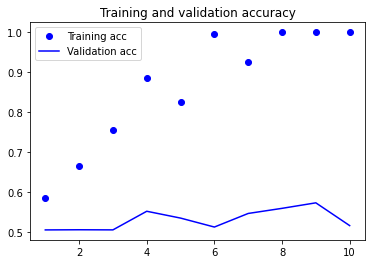

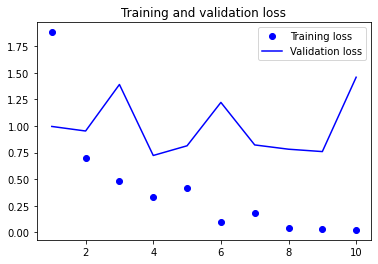

In [14]:
plt.show()

Overfits and validation accuracy has high variance, as expected (a very small training set)


Let's compare the performance of this model to training the embedding weights for the task in hand 

=> generally more powerful than pretrained word embeddings if dataset is copious

We have only 200 training samples... 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 73ms/step - loss: 0.6934 - acc: 0.5200 - val_loss: 0.6924 - val_acc: 0.5177
Epoch 2/10
7/7 [==============================] - 0s 51ms/step - loss: 0.5066 - acc: 0.9950 - val_loss: 0.6989 - 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

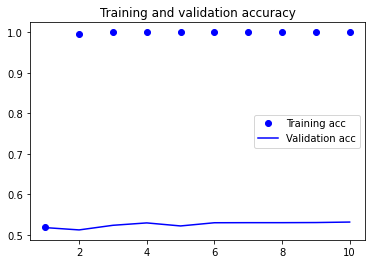

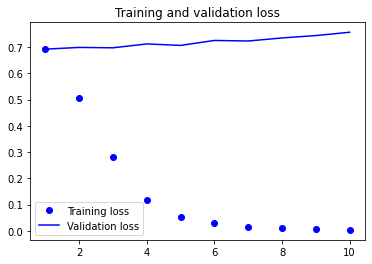

In [16]:
plt.show()

Validation accuracy stalls in the low 50s but the variance is low

Pretrained word embeddings have outperformed jointly learned embeddings in this small data example 

IDEA: try increasing training dateaset size - jointly-learned embeddings should eventually conquer

Let's tokenise the test data and evaluate the better model

In [17]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Load and evaluate the first model:

In [18]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 1.4892 - acc: 0.5127


[1.489208698272705, 0.512719988822937]

Test accuracy only narrowly beats a commonsense baseline!

DL is really struggling with this small dataset

----

## 6.140 Wrapping up

- Raw text must be processed into an acceptable form for neural network input
- Train task-specific embeddings with the `Embedding` layer
- Pretrained embeddings preferred for small data tasks

----

MIT Licence
 
Copyright (c) 2017-present François Chollet
 
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
 
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
 
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.